In [1]:
#import packages and functions

%load_ext autoreload
%autoreload 2

import pursuit_functions as pursuit
    
import pandas as pd
import numpy as np
import random
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
#load data set

all_pursuit_tasks = pd.read_parquet("ca1_ca3_rsc_pursuit_data.parquet", engine="pyarrow")

In [8]:
all_pursuit_tasks.head()

,time,ind,ratPos_1,ratPos_2,laserPos_1,laserPos_2,ratVel,ratAcc,laserVel,laserAcc,...,spkTable_28,spkTable_29,spkTable_30,spkTable_31,spkTable_32,spkTable_33,spkTable_34,region,trial_block,sessFile
0,46.71875,2804,136.375,127.6875,153.25,115.5625,28.453125,83.1875,30.0,27.328125,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,CA1,pursuit,KB09_20_pursuitRoot.mat
1,46.75,2805,136.5,127.25,153.25,114.9375,29.046875,83.4375,30.390625,30.21875,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,CA1,pursuit,KB09_20_pursuitRoot.mat
2,46.78125,2806,136.625,126.75,153.25,114.4375,29.671875,83.0,30.8125,33.0625,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,CA1,pursuit,KB09_20_pursuitRoot.mat
3,46.78125,2807,136.75,126.25,153.25,114.0,30.328125,81.8125,31.25,35.8125,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,CA1,pursuit,KB09_20_pursuitRoot.mat
4,46.8125,2808,137.0,125.75,153.375,113.5625,30.984375,79.875,31.71875,38.3125,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,CA1,pursuit,KB09_20_pursuitRoot.mat


In [9]:
print(all_pursuit_tasks["region"].unique())

['CA1' 'CA3' 'RSC']


In [3]:
RSC_sessions = all_pursuit_tasks[all_pursuit_tasks["region"] == "RSC"]

RSC_sessions_cleaned = RSC_sessions.dropna(subset=['ratPos_1', 'ratPos_2', 'laserPos_1', 'laserPos_2'])


In [8]:
print(RSC_sessions_cleaned.columns.tolist())

['time', 'ind', 'ratPos_1', 'ratPos_2', 'laserPos_1', 'laserPos_2', 'ratVel', 'ratAcc', 'laserVel', 'laserAcc', 'ratMoveDir', 'laserMoveDir', 'ratHeadDir', 'ratAV', 'laserAV', 'laserDist', 'laserBearingMD', 'laserBearingHD', 'centerDist', 'centerBearingMD', 'centerBearingHD', 'spkTable_1', 'spkTable_2', 'spkTable_3', 'spkTable_4', 'spkTable_5', 'spkTable_6', 'spkTable_7', 'spkTable_8', 'spkTable_9', 'spkTable_10', 'spkTable_11', 'spkTable_12', 'spkTable_13', 'spkTable_14', 'spkTable_15', 'spkTable_16', 'spkTable_17', 'spkTable_18', 'spkTable_19', 'spkTable_20', 'spkTable_21', 'spkTable_22', 'spkTable_23', 'spkTable_24', 'spkTable_25', 'spkTable_26', 'spkTable_27', 'spkTable_28', 'spkTable_29', 'spkTable_30', 'spkTable_31', 'spkTable_32', 'spkTable_33', 'spkTable_34', 'region', 'trial_block', 'sessFile']


In [4]:
RSC_sessions_cleaned["sessFile"].unique()

array(['KB10_02_pursuitRoot.mat', 'KB10_03_pursuitRoot.mat',
       'KB10_08_pursuitRoot.mat', 'KB10_09_pursuitRoot.mat',
       'KB10_10_pursuitRoot.mat', 'KB10_11_pursuitRoot.mat',
       'KB10_13_pursuitRoot.mat', 'KB10_15_pursuitRoot.mat',
       'KB10_17_pursuitRoot.mat', 'KB10_20_pursuitRoot.mat',
       'KB20_02_pursuitRoot.mat', 'KB20_03_pursuitRoot.mat',
       'KB20_04_pursuitRoot.mat', 'KB20_05_pursuitRoot.mat',
       'KB20_06_pursuitRoot.mat', 'KB20_07_pursuitRoot.mat',
       'KB20_09_pursuitRoot.mat', 'KB20_10_pursuitRoot.mat',
       'KB20_11_pursuitRoot.mat', 'KB20_12_pursuitRoot.mat',
       'KB20_13_pursuitRoot.mat', 'KB20_14_pursuitRoot.mat',
       'KB20_15_pursuitRoot.mat', 'KB20_19_pursuitRoot.mat',
       'KB20_21_pursuitRoot.mat', 'KB20_22_pursuitRoot.mat',
       'KB20_24_pursuitRoot.mat', 'KB20_25_pursuitRoot.mat',
       'KB20_26_pursuitRoot.mat', 'KB20_34_pursuitRoot.mat',
       'KB20_35_pursuitRoot.mat', 'LP03_03_pursuitRoot.mat',
       'LP03_04_pursuitR

In [ ]:
#get values below 99th percentile and normalize points 

def normalize_points(dataframe, rat_x, rat_y, laser_x, laser_y):

    normalized_data = []
    
    for sessFile in dataframe["sessFile"].unique():
        rat_x_vals = dataframe[dataframe["sessFile"] == sessFile][rat_x].values.astype("float64")
        rat_y_vals = dataframe[dataframe["sessFile"] == sessFile][rat_y].values.astype("float64")
        laser_x_vals = dataframe[dataframe["sessFile"] == sessFile][laser_x].values.astype("float64")
        laser_y_vals = dataframe[dataframe["sessFile"] == sessFile][laser_y].values.astype("float64")

        x = np.concatenate((rat_x_vals, laser_x_vals))
        y = np.concatenate((rat_y_vals, laser_y_vals))
            
        #identify 99th percentile x, y boundaries
        x_low, x_high = np.percentile(x, [0, 99])
        y_low, y_high = np.percentile(y, [0, 99])

        #filter the data so we only get the data under the 99th percentile
        filter = (x >= x_low) & (x <= x_high) & (y >= y_low) & (y <= y_high)
        x_filtered = x[filter]
        y_filtered = y[filter]

        #normalize the points to the origin
        x_normalized = x_filtered - x_low
        y_normalized = y_filtered - y_low

        for xn, yn in zip(x_normalized, y_normalized):
            normalized_data.append({
                "sessFile": sessFile,
                "x_normalized": xn,
                "y_normalized": yn,
                "x_low": x_low,
                "x_high": x_high, 
                "y_low": y_low, 
                "y_high": y_high
            })
    normalized_df = pd.DataFrame(normalized_data)

    return normalized_df


RSC_sessions_normalized = normalize_points(RSC_sessions_cleaned, "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")
RSC_sessions_normalized.head()
        

                  sessFile  x_normalized  y_normalized    x_low  x_high  \
0  KB10_02_pursuitRoot.mat       95.3125     98.445312  76.1875   186.5   
1  KB10_02_pursuitRoot.mat      106.4375     90.570312  76.1875   186.5   
2  KB10_02_pursuitRoot.mat      106.3125     90.632812  76.1875   186.5   
3  KB10_02_pursuitRoot.mat       99.8125     85.257812  76.1875   186.5   
4  KB10_02_pursuitRoot.mat       99.8125     85.132812  76.1875   186.5   

       y_low  y_high  
0  10.367188  132.75  
1  10.367188  132.75  
2  10.367188  132.75  
3  10.367188  132.75  
4  10.367188  132.75  


In [34]:
def normalize_rat_points(dataframe, rat_x, rat_y):

    normalized_data = []
    
    for sessFile in dataframe["sessFile"].unique():
        rat_x_vals = dataframe[dataframe["sessFile"] == sessFile][rat_x].values.astype("float64")
        rat_y_vals = dataframe[dataframe["sessFile"] == sessFile][rat_y].values.astype("float64")
   
        #identify 99th percentile x, y boundaries
        x_low, x_high = np.percentile(rat_x_vals, [0, 99])
        y_low, y_high = np.percentile(rat_y_vals, [0, 99])

        #filter the data so we only get the data under the 99th percentile
        filter = (rat_x_vals >= x_low) & (rat_x_vals <= x_high) & (rat_y_vals >= y_low) & (rat_y_vals <= y_high)
        x_filtered = rat_x_vals[filter]
        y_filtered = rat_y_vals[filter]

        #normalize the points to the origin
        x_normalized = x_filtered - x_low
        y_normalized = y_filtered - y_low

        for xn, yn in zip(x_normalized, y_normalized):
            normalized_data.append({
                "sessFile": sessFile,
                "rat_x_normalized": xn,
                "rat_y_normalized": yn
            })
    rat_normalized_df = pd.DataFrame(normalized_data)

    return rat_normalized_df


RSC_sessions_rat_normalized = normalize_rat_points(RSC_sessions_cleaned, "ratPos_1", "ratPos_2")
RSC_sessions_rat_normalized.head()
        

,sessFile,rat_x_normalized,rat_y_normalized
0,KB10_02_pursuitRoot.mat,94.8125,98.445312
1,KB10_02_pursuitRoot.mat,112.5625,90.195312
2,KB10_02_pursuitRoot.mat,112.5625,90.320312
3,KB10_02_pursuitRoot.mat,112.6875,90.382812
4,KB10_02_pursuitRoot.mat,105.9375,90.570312


In [35]:
def normalize_laser_points(dataframe, laser_x, laser_y):

    normalized_data = []
    
    for sessFile in dataframe["sessFile"].unique():
        laser_x_vals = dataframe[dataframe["sessFile"] == sessFile][laser_x].values.astype("float64")
        laser_y_vals = dataframe[dataframe["sessFile"] == sessFile][laser_y].values.astype("float64")
   
        #identify 99th percentile x, y boundaries
        x_low, x_high = np.percentile(laser_x_vals, [0, 99])
        y_low, y_high = np.percentile(laser_y_vals, [0, 99])

        #filter the data so we only get the data under the 99th percentile
        filter = (laser_x_vals >= x_low) & (laser_x_vals <= x_high) & (laser_y_vals >= y_low) & (laser_y_vals <= y_high)
        x_filtered = laser_x_vals[filter]
        y_filtered = laser_y_vals[filter]

        #normalize the points to the origin
        x_normalized = x_filtered - x_low
        y_normalized = y_filtered - y_low

        for xn, yn in zip(x_normalized, y_normalized):
            normalized_data.append({
                "sessFile": sessFile,
                "laser_x_normalized": xn,
                "laser_y_normalized": yn
            })
    laser_normalized_df = pd.DataFrame(normalized_data)

    return laser_normalized_df


RSC_sessions_laser_normalized = normalize_laser_points(RSC_sessions_cleaned, "laserPos_1", "laserPos_2")
RSC_sessions_laser_normalized.head()

,sessFile,laser_x_normalized,laser_y_normalized
0,KB10_02_pursuitRoot.mat,98.4375,95.976562
1,KB10_02_pursuitRoot.mat,100.1875,78.851562
2,KB10_02_pursuitRoot.mat,99.6875,79.101562
3,KB10_02_pursuitRoot.mat,99.9375,78.851562
4,KB10_02_pursuitRoot.mat,100.1875,78.601562


In [24]:
#find center of arena and radius to find boundaries
def circle_fit_mean(dataframe, x_norm, y_norm):

    results = []
    x_centers = []
    y_centers = []
    radii = []

    for sessFile in dataframe["sessFile"].unique():
            
        x_normalized = dataframe[dataframe["sessFile"] == sessFile][x_norm].values.astype("float64")
        y_normalized = dataframe[dataframe["sessFile"] == sessFile][y_norm].values.astype("float64")

        #A * [a,b,c].T = b_vec
        A = np.column_stack((-2*x_normalized, -2*y_normalized, np.ones_like(x_normalized)))
        b_vec = -(x_normalized**2 + y_normalized**2)

        solution, residuals, rank, s = np.linalg.lstsq(A, b_vec)
        a, b, c = solution

        r = np.sqrt(a**2 + b**2 - c)

        x_centers.append(a)
        y_centers.append(b)
        radii.append(r)
     
        results.append({
               "sessFile": sessFile,
               "center_x": a,
               "center_y": b,
                "radius": r
                })
        
    mean_x = np.mean(x_centers)
    mean_y = np.mean(y_centers)
    mean_r = np.mean(radii)  

    for value in results:
            value["mean_x"] = mean_x
            value["mean_y"] = mean_y
            value["mean_radius"] = mean_r

    center_radius_vals = pd.DataFrame(results)

    return center_radius_vals, mean_x, mean_y, mean_r

#center_x, center_y, radius = circle_fit(RSC_sessions_cleaned[RSC_sessions_cleaned["sessFile"] == 'KB10_02_pursuitRoot.mat'], "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")
RSC_center_radius_vals, mean_center_x, mean_center_y, mean_radius = circle_fit_mean(RSC_sessions_normalized, "x_normalized", "y_normalized")

print(RSC_center_radius_vals)
print(mean_center_x, mean_center_y)
print(mean_radius)



                   sessFile   center_x   center_y     radius     mean_x  \
0   KB10_02_pursuitRoot.mat  56.545900  68.999099  36.978975  64.481824   
1   KB10_03_pursuitRoot.mat  67.392966  66.742267  39.812800  64.481824   
2   KB10_08_pursuitRoot.mat  63.266996  70.605327  39.566583  64.481824   
3   KB10_09_pursuitRoot.mat  60.410154  67.693100  39.361477  64.481824   
4   KB10_10_pursuitRoot.mat  62.515438  71.147845  42.114953  64.481824   
5   KB10_11_pursuitRoot.mat  60.050804  68.657599  42.923043  64.481824   
6   KB10_13_pursuitRoot.mat  60.859039  63.536542  41.986945  64.481824   
7   KB10_15_pursuitRoot.mat  62.788113  69.289069  43.770704  64.481824   
8   KB10_17_pursuitRoot.mat  70.223582  69.358819  43.392407  64.481824   
9   KB10_20_pursuitRoot.mat  61.487838  65.117761  39.862554  64.481824   
10  KB20_02_pursuitRoot.mat  64.187963  64.764520  42.700862  64.481824   
11  KB20_03_pursuitRoot.mat  69.085743  66.718816  39.798069  64.481824   
12  KB20_04_pursuitRoot.m

In [46]:
RSC_center_radius_vals

,sessFile,center_x,center_y,radius,mean_x,mean_y,mean_radius
0,KB10_02_pursuitRoot.mat,56.545900,68.999099,36.978975,64.481824,66.010097,41.726686
1,KB10_03_pursuitRoot.mat,67.392966,66.742267,39.812800,64.481824,66.010097,41.726686
2,KB10_08_pursuitRoot.mat,63.266996,70.605327,39.566583,64.481824,66.010097,41.726686
3,KB10_09_pursuitRoot.mat,60.410154,67.693100,39.361477,64.481824,66.010097,41.726686
4,KB10_10_pursuitRoot.mat,62.515438,71.147845,42.114953,64.481824,66.010097,41.726686
5,KB10_11_pursuitRoot.mat,60.050804,68.657599,42.923043,64.481824,66.010097,41.726686
6,KB10_13_pursuitRoot.mat,60.859039,63.536542,41.986945,64.481824,66.010097,41.726686
7,KB10_15_pursuitRoot.mat,62.788113,69.289069,43.770704,64.481824,66.010097,41.726686
8,KB10_17_pursuitRoot.mat,70.223582,69.358819,43.392407,64.481824,66.010097,41.726686
9,KB10_20_pursuitRoot.mat,61.487838,65.117761,39.862554,64.481824,66.010097,41.726686


In [26]:
def circ_bounds(x, y, r):
    
    num_points = 360
    circumference = 2 * np.pi * r

    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

    x_points = x + r * np.cos(angles)
    y_points = y + r * np.sin(angles)

    return circumference, x_points, y_points

circumference, x_circ, y_circ = circ_bounds(mean_center_x, mean_center_y, mean_radius)

print(circumference)
print(x_circ)
print(y_circ)


262.1765030295257
[106.20851083 106.20215566 106.18309206 106.15132586 106.10686672
 106.0497282  105.97992768 105.89748644 105.80242959 105.69478608
 105.57458871 105.44187408 105.29668262 105.13905857 104.96904992
 104.78670847 104.59208977 104.38525309 104.16626144 103.93518152
 103.69208373 103.43704212 103.17013437 102.89144178 102.60104926
 102.29904524 101.98552174 101.66057425 101.32430175 100.97680667
 100.61819487 100.24857558  99.86806139  99.47676821  99.07481524
  98.6623249   98.23942285  97.80623791  97.36290203  96.90955025
  96.44632068  95.97335441  95.49079551  94.99879098  94.49749069
  93.98704734  93.46761641  92.93935612  92.4024274   91.85699379
  91.30322144  90.74127903  90.17133774  89.59357117  89.00815532
  88.41526851  87.81509135  87.20780664  86.59359938  85.97265666
  85.34516762  84.71132341  84.0713171   83.42534364  82.77359979
  82.1162841   81.45359678  80.78573969  80.11291627  79.43533147
  78.75319168  78.0667047   77.37607964  76.68152686  75.9

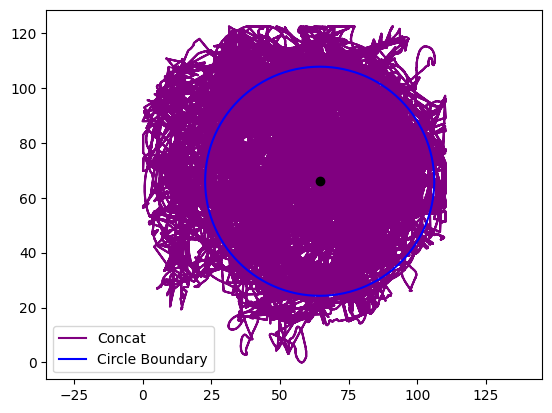

In [45]:
#plot example normalized trajectories and boundaries


#laser_subset = RSC_sessions_laser_normalized[RSC_sessions_laser_normalized["sessFile"] == 'KB10_02_pursuitRoot.mat']
#rat_subset = RSC_sessions_rat_normalized[RSC_sessions_rat_normalized["sessFile"] == 'KB10_02_pursuitRoot.mat']
concat_subset = RSC_sessions_normalized[RSC_sessions_normalized["sessFile"] == 'KB10_02_pursuitRoot.mat']

#plt.plot(laser_subset["laser_x_normalized"], laser_subset["laser_y_normalized"], color='red', zorder=2, label='Laser')
#plt.plot(rat_subset["rat_x_normalized"], rat_subset["rat_y_normalized"], color='blue', zorder=2, label='Rat')
plt.plot(concat_subset["x_normalized"], concat_subset["y_normalized"], color='purple', zorder=2, label='Concat')

plt.scatter(mean_center_x, mean_center_y, color='black', zorder=5)

plt.plot(x_circ, y_circ, 'b-', zorder=10, label='Circle Boundary')

plt.axis('equal')
plt.legend()
plt.show()

In [ ]:
#find center of arena and radius to find boundaries

def circle_fit_mean(dataframe, rat_x, rat_y, laser_x, laser_y):

    results = []

    for sessFile in dataframe["sessFile"].unique():
            
            rat_x_vals = dataframe[dataframe["sessFile"] == sessFile][rat_x].values.astype("float64")
            rat_y_vals = dataframe[dataframe["sessFile"] == sessFile][rat_y].values.astype("float64")
            laser_x_vals = dataframe[dataframe["sessFile"] == sessFile][laser_x].values.astype("float64")
            laser_y_vals = dataframe[dataframe["sessFile"] == sessFile][laser_y].values.astype("float64")

            x = np.concatenate((rat_x_vals, laser_x_vals))
            y = np.concatenate((rat_y_vals, laser_y_vals))
            
            #identify 99th percentile x, y boundaries
            x_low, x_high = np.percentile(x, [0, 99])
            y_low, y_high = np.percentile(y, [0, 99])

            #filter the data so we only get the 
            filter = (x >= x_low) & (x <= x_high) & (y >= y_low) & (y <= y_high)
            x_filtered = x[filter]
            y_filtered = y[filter]

            #normalize the points to the origin
            x_normalized = x_filtered - x_low
            y_normalized = y_filtered - y_low

            #A * [a,b,c].T = b_vec
            A = np.column_stack((-2*x_normalized, -2*y_normalized, np.ones_like(x_normalized)))
            b_vec = -(x_normalized**2 + y_normalized**2)

            solution, residuals, rank, s = np.linalg.lstsq(A, b_vec)
            a, b, c = solution

            r = np.sqrt(a**2 + b**2 - c)
            
            results.append([a, b, r])

    results_array = np.array(results)

    mean_values = results_array.mean(axis=0)     
    mean_a, mean_b, mean_r = mean_values        
    
    return results_array, mean_a, mean_b, mean_r, x_low, x_high, y_low, y_high

#center_x, center_y, radius = circle_fit(RSC_sessions_cleaned[RSC_sessions_cleaned["sessFile"] == 'KB10_02_pursuitRoot.mat'], "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")
results_array, mean_center_x, mean_center_y, mean_radius, x_low, x_high, y_low, y_high = circle_fit_mean(RSC_sessions_cleaned, "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")

print(results_array)
print(mean_center_x, mean_center_y)
print(mean_radius)



[[56.54590001 68.99909854 36.9789753 ]
 [67.39296583 66.74226733 39.81280002]
 [63.26699581 70.60532678 39.56658309]
 [60.41015356 67.69309991 39.36147706]
 [62.51543769 71.14784537 42.11495337]
 [60.05080439 68.65759919 42.92304261]
 [60.85903889 63.53654203 41.98694496]
 [62.78811348 69.28906876 43.77070422]
 [70.22358192 69.35881933 43.39240691]
 [61.4878381  65.11776115 39.86255432]
 [64.18796293 64.76451962 42.70086171]
 [69.08574342 66.71881642 39.79806924]
 [65.76078966 64.11815702 39.83569552]
 [64.45147256 67.10122023 39.9755984 ]
 [69.26552458 68.63807847 39.52164082]
 [67.21042939 65.20766125 42.65391531]
 [67.69854138 68.00420731 39.8498649 ]
 [65.34847524 68.15985193 41.14479688]
 [64.65898286 66.59832143 39.43403845]
 [66.95172868 68.00730857 44.45638973]
 [68.30821348 64.49326369 43.31637265]
 [64.23880796 60.93320882 42.39190735]
 [66.02060958 60.86283803 42.41964363]
 [67.17531481 64.11514565 42.50819746]
 [66.01425026 60.85958572 43.44525196]
 [66.45217374 63.24002002

In [26]:
def circle_fit(dataframe, rat_x, rat_y, laser_x, laser_y):

    rat_x_vals = dataframe[rat_x].values.astype("float64")
    rat_y_vals = dataframe[rat_y].values.astype("float64")
    laser_x_vals = dataframe[laser_x].values.astype("float64")
    laser_y_vals = dataframe[laser_y].values.astype("float64")
            
    x = np.concatenate((rat_x_vals, laser_x_vals))
    y = np.concatenate((rat_y_vals, laser_y_vals))
            
    #A * [a,b,c].T = b_vec
    A = np.column_stack((-2*x, -2*y, np.ones_like(x)))
    b_vec = -(x**2 + y**2)

    solution, residuals, rank, s = np.linalg.lstsq(A, b_vec)
    a, b, c = solution

    r = np.sqrt(a**2 + b**2 - c)
                 
    return a, b, r

#center_x, center_y, radius = circle_fit(RSC_sessions_cleaned[RSC_sessions_cleaned["sessFile"] == 'KB10_02_pursuitRoot.mat'], "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")
center_x, center_y, radius = circle_fit(RSC_sessions_cleaned, "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")

print(center_x, center_y)
print(radius)


132.37856945934644 85.41859633085595
44.172068888133516


In [50]:
#find 99th percentile of max arena boundaries

def arena_bounds_99(dataframe, rat_x, rat_y, laser_x, laser_y):

    rat_x_vals = dataframe[rat_x].values.astype("float64")
    rat_y_vals = dataframe[rat_y].values.astype("float64")
    laser_x_vals = dataframe[laser_x].values.astype("float64")
    laser_y_vals = dataframe[laser_y].values.astype("float64")

    x = np.concatenate((rat_x_vals, laser_x_vals))
    y = np.concatenate((rat_y_vals, laser_y_vals))

    x_low, x_high = np.percentile(x, [1, 99])
    y_low, y_high = np.percentile(y, [1, 99])

    #arena_x_bounds = (x_low, x_high)
    #arena_y_bounds = (y_low, y_high)

    #calculate center of points
    center_x = np.median([x_low, x_high])
    center_y = np.median([y_low, y_high])

    #distance of center to boundary point
    x_low_y_values = dataframe.loc[dataframe[rat_x] == x_low, rat_y].values.astype("float64")

    if x_low_y_values.size > 0:
        idx = np.argmin(np.abs(x_low_y_values - center_y))
        x_low_y = x_low_y_values[idx]
    else:
        raise ValueError ("There's no matching y value found for x_low")
    
    distance = np.sqrt((x_low - center_x)**2 + (x_low_y - center_y)**2)
    
    return center_x, center_y, distance, x_low, x_high, y_low, y_high

#center_x, center_y, radius = arena_bounds_99(RSC_sessions_cleaned, "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")
center_x, center_y, radius, x_low, x_high, y_low, y_high = arena_bounds_99(RSC_sessions_cleaned[RSC_sessions_cleaned["sessFile"] == 'KB10_02_pursuitRoot.mat'], "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")

print(center_x, center_y)
print(radius)

134.8125 80.484375
51.733110260892154


c:\Users\maygc\Miniconda3\envs\pursuit\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\maygc\Miniconda3\envs\pursuit\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


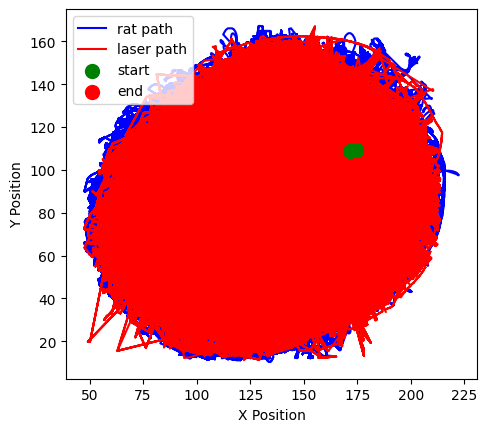

In [ ]:
#plot trajectories

pursuit.plot.plot_trajectory(RSC_sessions_cleaned, rat_color='blue', laser_color='red')

/Users/may/Projects/pursuit/pursuit_functions/plot.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


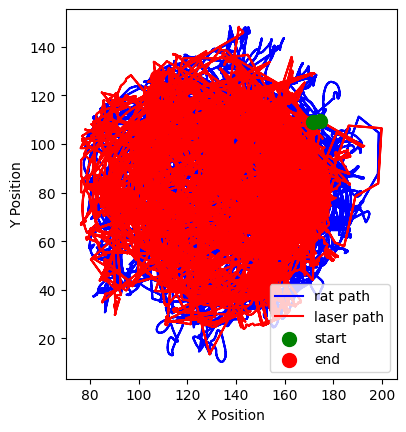

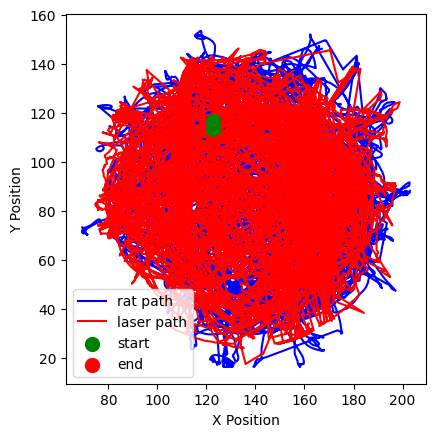

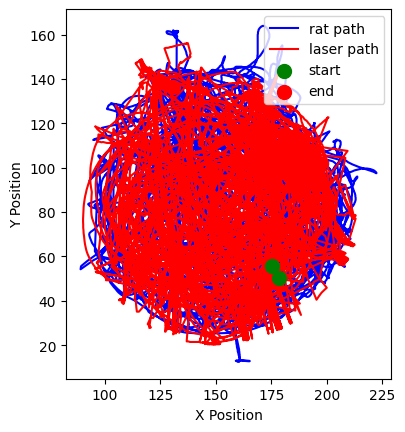

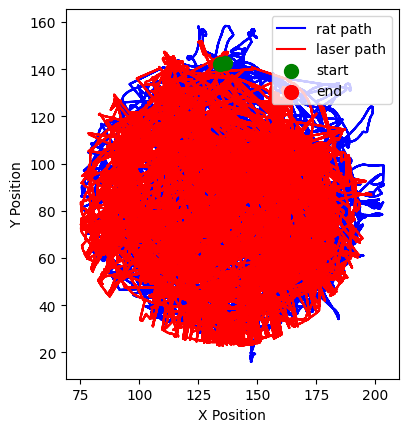

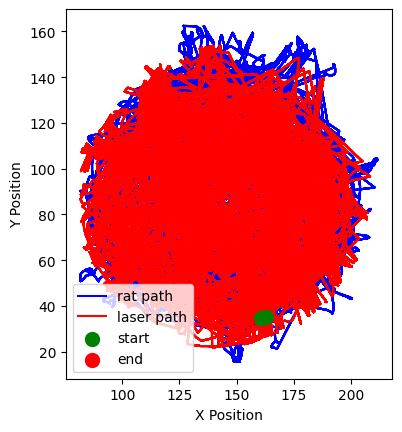

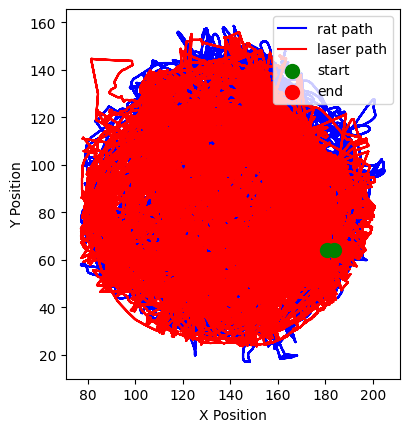

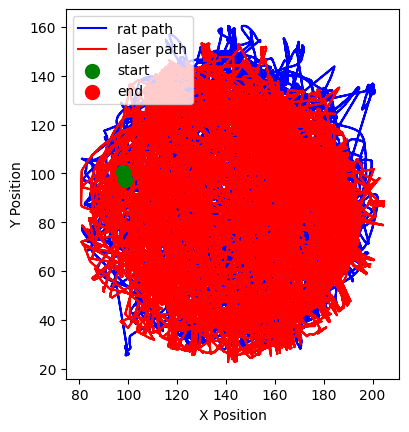

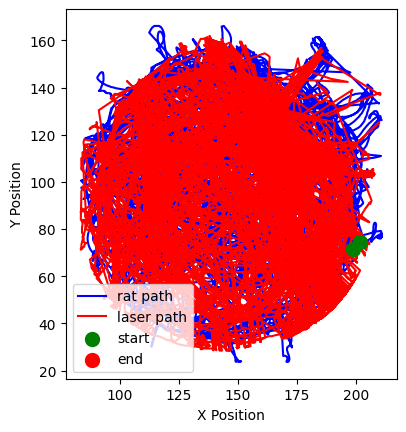

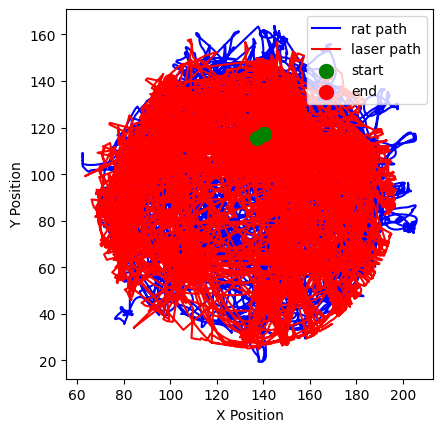

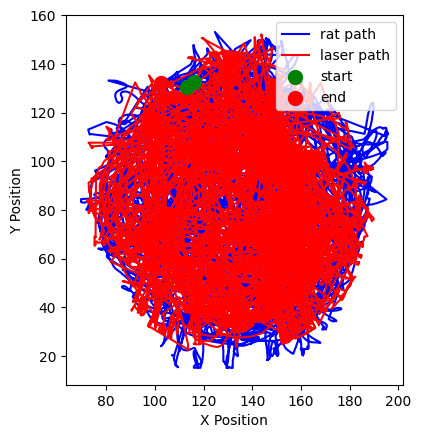

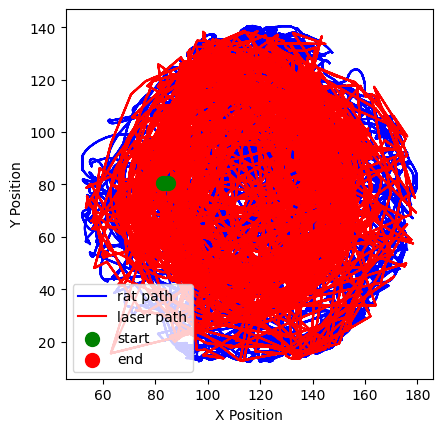

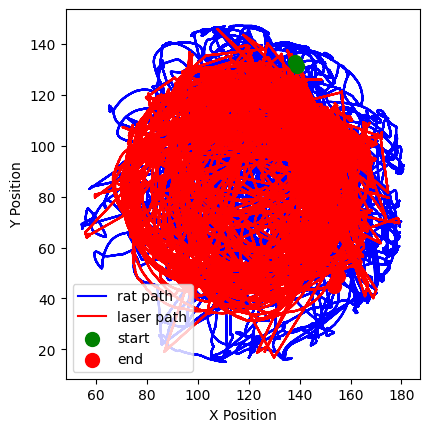

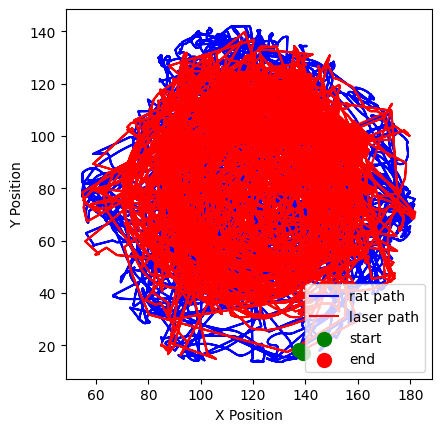

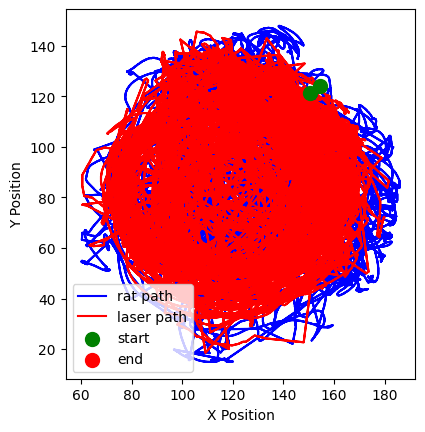

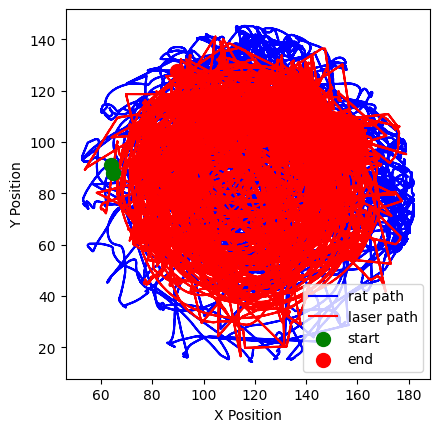

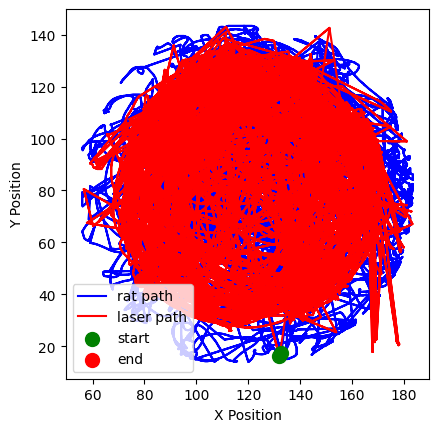

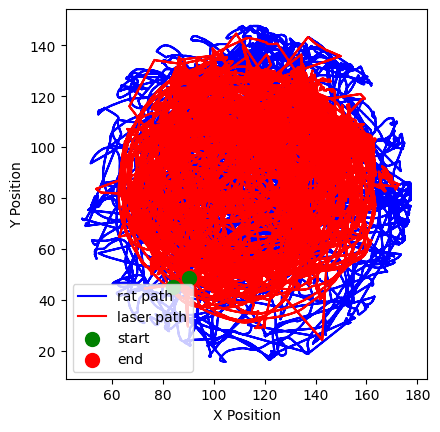

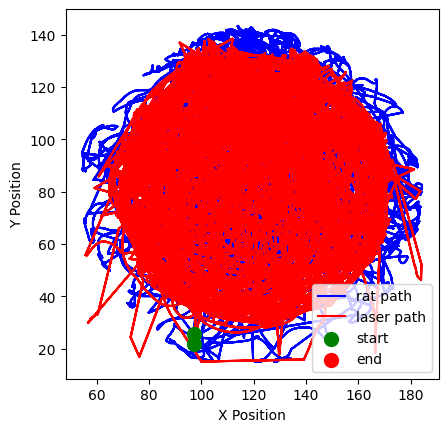

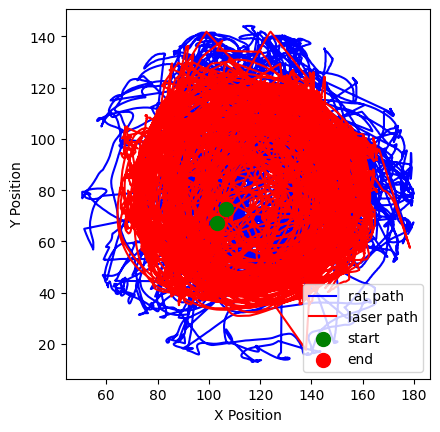

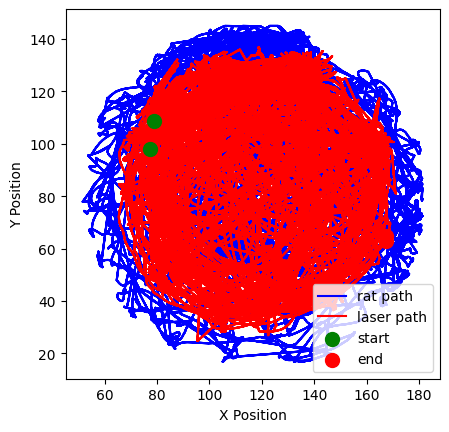

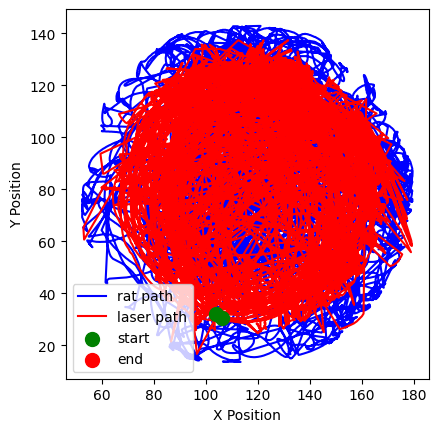

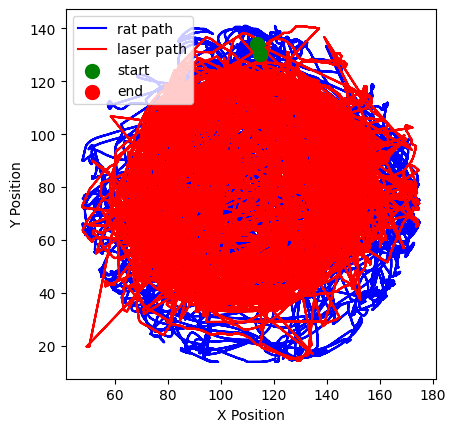

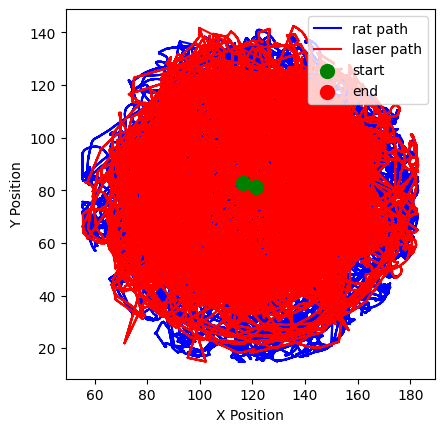

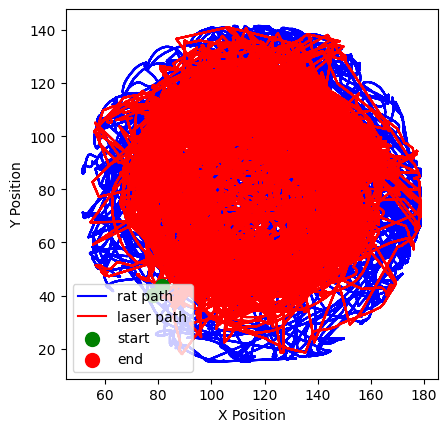

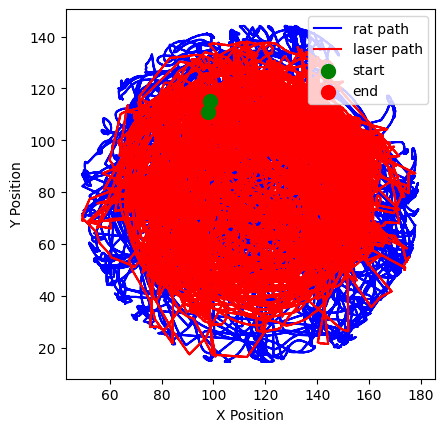

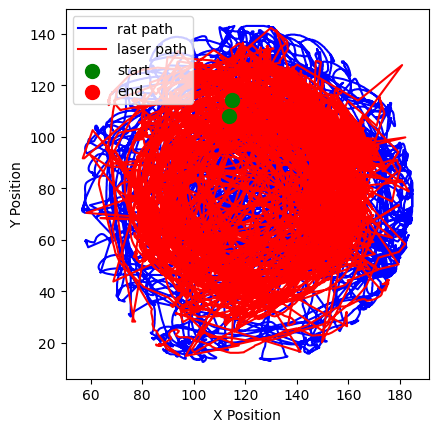

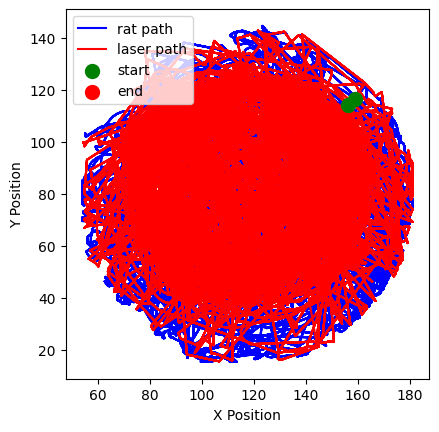

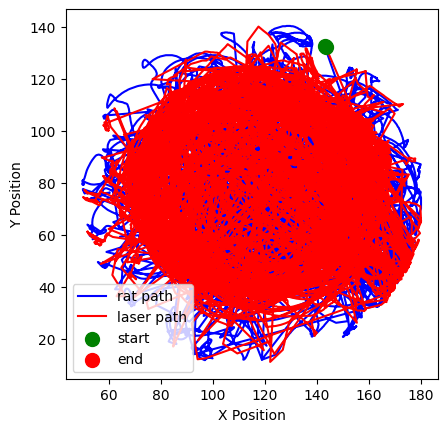

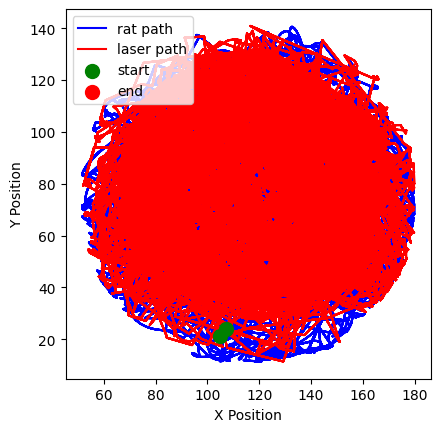

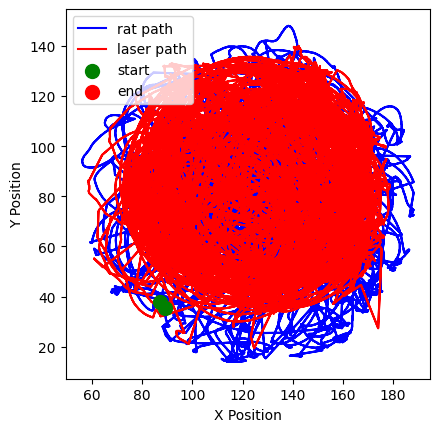

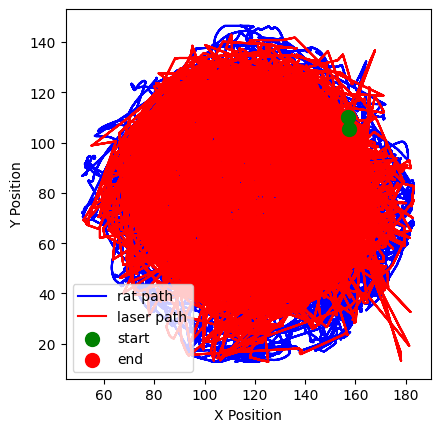

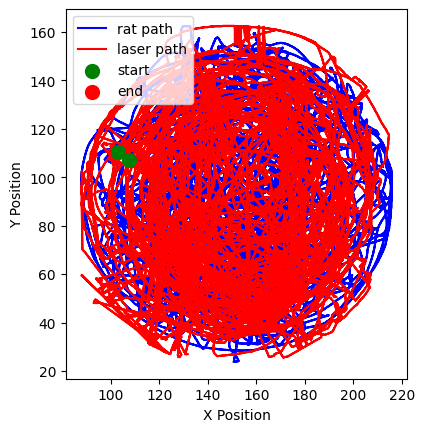

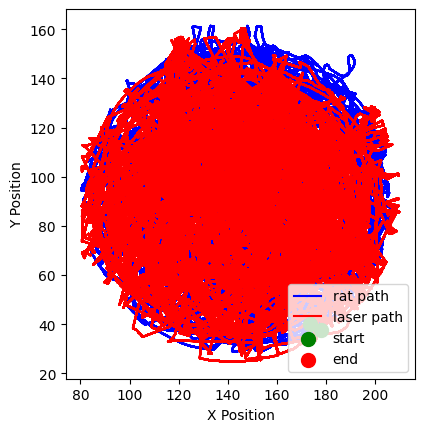

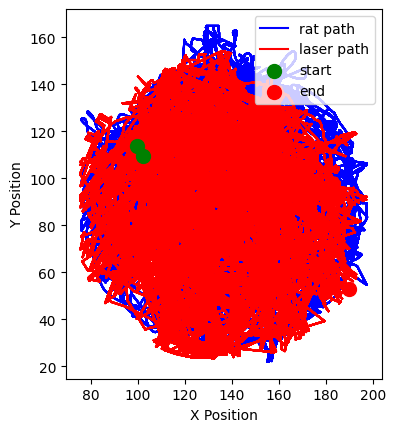

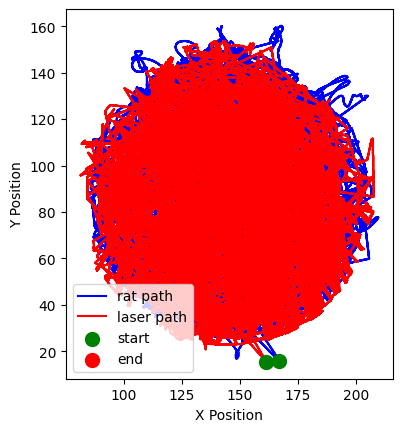

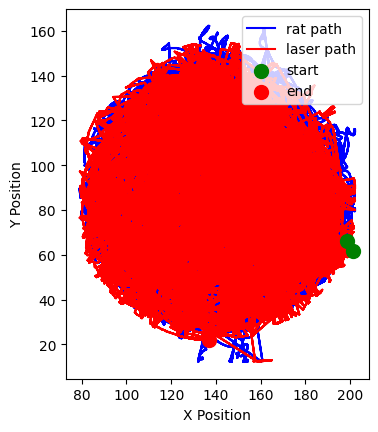

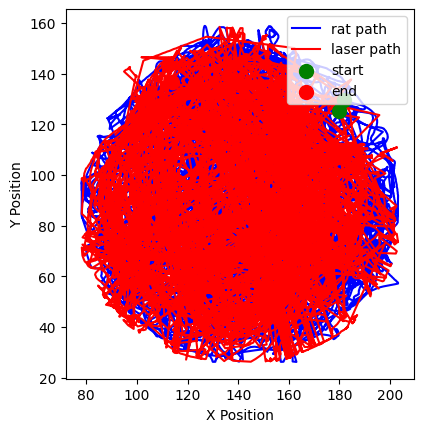

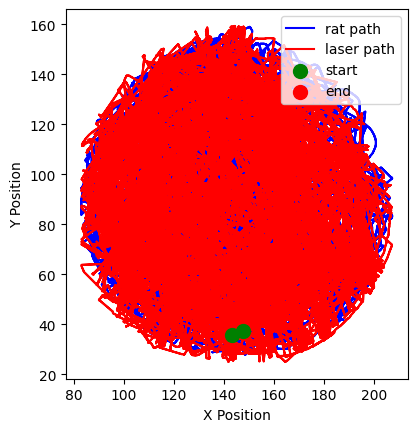

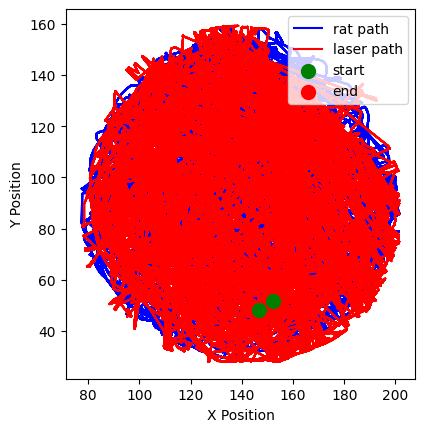

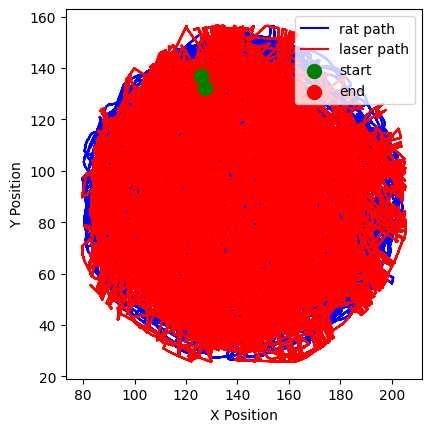

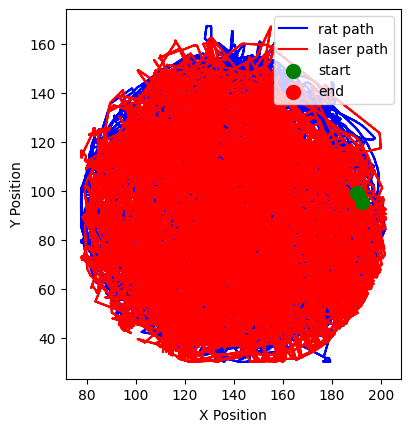

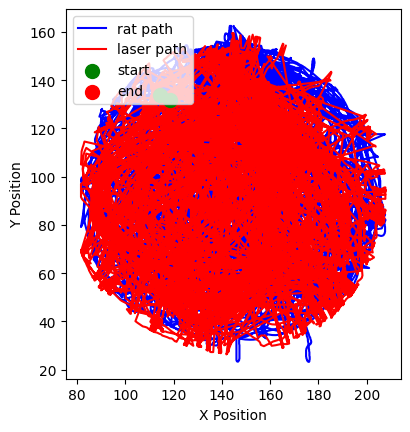

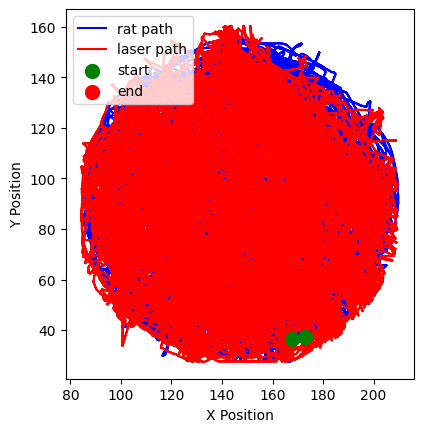

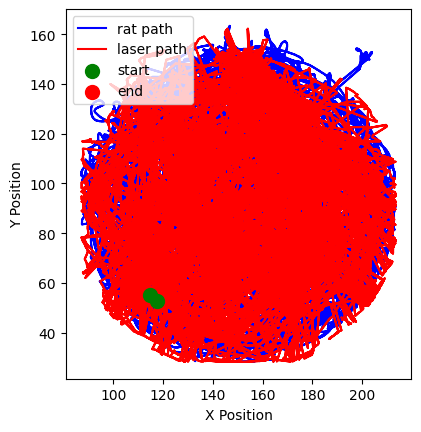

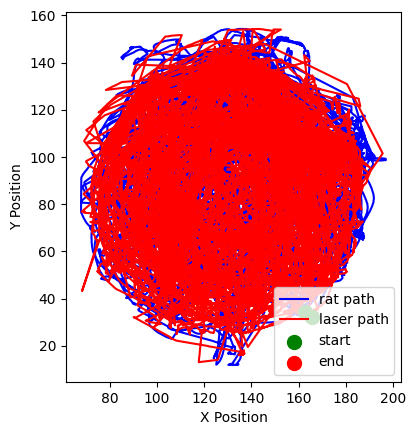

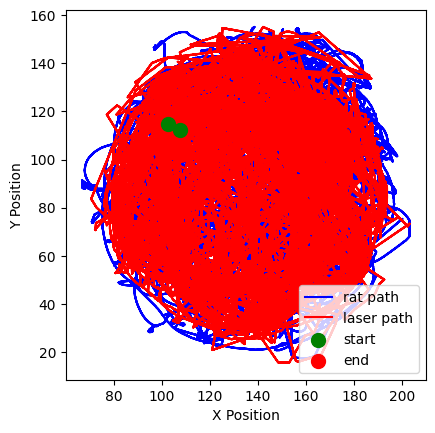

In [23]:
for sessFile in RSC_sessions_cleaned["sessFile"].unique():
    session = RSC_sessions_cleaned[RSC_sessions_cleaned["sessFile"]== sessFile]
    pursuit.plot.plot_trajectory(session, rat_color='blue', laser_color='red')